In [2]:
from pathlib import Path
from kedro.framework.startup import configure_project
from kedro.framework.session import KedroSession

# Remplace par le nom de ton package (si c’est "edf_energy_forecast", garde ça)
project_path = Path("../").resolve()
configure_project("edf_energy_forecast")

session = KedroSession.create(project_path)
context = session.load_context()
catalog = context.catalog

df_corrige = catalog.load("df_corrige")
df_corrige.head()

[05/11/25 23:14:13] INFO     Using                                                                  ]8;id=281751;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=109393;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\f                
                             ramework\project\rich_logging.yml' as logging configuration.                          

[05/11/25 23:14:14] WARNING  C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\io ]8;id=824872;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=310948;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             \data_catalog.py:165: KedroDeprecationWarning: `DataCatalog` has been                 
                             deprecated and will be replaced by `KedroDataCatalog`, in Kedro                       
                             1.0.0.Currently some `KedroDataCatalog` APIs have been retained for                   
                             compatibility with `DataCatalog`, including the `datasets` property                   
                             and the `get_datasets`, `_get_datasets`, `add`,` list`,                               
                             `add_feed_dict`, and `shallow_copy` methods. These will be removed or                 
                             replaced with updated alternatives in Kedro 1.0.0. For more details,                  
                             refer to the documentation:                                                           
                             https://docs.kedro.org/en/stable/data/index.html#kedrodatacatalog-expe                
                             rimental-feature                                                                      
                               warnings.warn(                                                                      
                                                                                                                   

[05/11/25 23:14:17] WARNING  C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\io ]8;id=216618;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=976669;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             \data_catalog.py:165: KedroDeprecationWarning: `DataCatalog` has been                 
                             deprecated and will be replaced by `KedroDataCatalog`, in Kedro                       
                             1.0.0.Currently some `KedroDataCatalog` APIs have been retained for                   
                             compatibility with `DataCatalog`, including the `datasets` property                   
                             and the `get_datasets`, `_get_datasets`, `add`,` list`,                               
                             `add_feed_dict`, and `shallow_copy` methods. These will be removed or                 
                             replaced with updated alternatives in Kedro 1.0.0. For more details,                  
                             refer to the documentation:                                                           
                             https://docs.kedro.org/en/stable/data/index.html#kedrodatacatalog-expe                
                             rimental-feature                                                                      
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=343619;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=952011;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro_telemetry\plugin.py#233\233]8;;\
                             the product. No personal data or IP addresses are stored on our side. If              
                             you want to opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK`              
                             environment variables, or create a `.telemetry` file in the current                   
                             working directory with the contents `consent: false`. Read more at                    
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[05/11/25 23:14:18] INFO     Loading data from df_corrige (CSVDataSet)...                       ]8;id=692697;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=196113;file://C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\kedro\io\data_catalog.py#401\401]8;;\

,Type de jour TEMPO,Date,Heures,Prévision J,Prévision J-1,Consommation,Jour,Weekend,Saison
0,BLEU,2014-09-01,00:00,42500.0,42600.0,43320.0,Lundi,0,Automne
1,BLEU,2014-09-01,00:30,40300.0,40300.0,41174.0,Lundi,0,Automne
2,BLEU,2014-09-01,01:00,38000.0,37800.0,38430.0,Lundi,0,Automne
3,BLEU,2014-09-01,01:30,38300.0,37800.0,37800.0,Lundi,0,Automne
4,BLEU,2014-09-01,02:00,37400.0,37400.0,37137.0,Lundi,0,Automne


In [3]:
features = [
    "Consommation",
    "Prévision J-1",
    "Weekend"
    # Tu peux en ajouter d’autres si tu veux
]


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_corrige[features])


In [5]:
import numpy as np

def create_sequences(data, target_index, timesteps):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i])
        y.append(data[i, target_index])
    return np.array(X), np.array(y)

timesteps = 10
target_index = features.index("Consommation")
X, y = create_sequences(data_scaled, target_index, timesteps)


In [6]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [7]:
import mlflow
import mlflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [8]:
# Démarrer un run MLflow
with mlflow.start_run(run_name="LSTM - Consommation EDF"):

    # Architecture du modèle
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")

    # Entraînement
    es = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        callbacks=[es],
        verbose=0
    )


[05/11/25 23:20:39] WARNING  C:\Users\boudj\edf-energy-forecast\kedro310\lib\site-packages\keras\sr ]8;id=986951;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=645516;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             c\layers\rnn\rnn.py:200: UserWarning: Do not pass an                                  
                             `input_shape`/`input_dim` argument to a layer. When using Sequential                  
                             models, prefer using an `Input(shape)` object as the first layer in                   
                             the model instead.                                                                    
                               super().__init__(**kwargs)                                                          
                                                                                                                   

In [9]:
# Prédiction
y_pred = model.predict(X_test).flatten()

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ LSTM terminé - RMSE: {rmse:.2f} | R²: {r2:.4f}")


1402/1402 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
✅ LSTM terminé - RMSE: 0.01 | R²: 0.9976


In [10]:
y_train_pred = model.predict(X_train).flatten()

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

print(f"🔍 Train RMSE: {rmse_train:.4f} | R²: {r2_train:.4f}")


5607/5607 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step
🔍 Train RMSE: 0.0116 | R²: 0.9954


In [11]:
pip install workalendar

     ---------------------------------------- 0.0/5.8 MB ? eta -:--:--
     - -------------------------------------- 0.3/5.8 MB ? eta -:--:--
     --- ------------------------------------ 0.5/5.8 MB 1.4 MB/s eta 0:00:04
     ----- ---------------------------------- 0.8/5.8 MB 1.5 MB/s eta 0:00:04
     ------- -------------------------------- 1.0/5.8 MB 1.5 MB/s eta 0:00:04
     ---------- ----------------------------- 1.6/5.8 MB 1.6 MB/s eta 0:00:03
     ------------ --------------------------- 1.8/5.8 MB 1.6 MB/s eta 0:00:03
     ---------------- ----------------------- 2.4/5.8 MB 1.7 MB/s eta 0:00:02
     ------------------ --------------------- 2.6/5.8 MB 1.7 MB/s eta 0:00:02
     -------------------- ------------------- 2.9/5.8 MB 1.7 MB/s eta 0:00:02
     ----------------------- ---------------- 3.4/5.8 MB 1.7 MB/s eta 0:00:02
     ------------------------- -------------- 3.7/5.8 MB 1.7 MB/s eta 0:00:02
     --------------------------- ------------ 3.9/5.8 MB 1.7 MB/s eta 0:00:02


  DEPRECATION: Building 'pymeeus' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pymeeus'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [12]:
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, FR

# Créer une colonne DateTime complète
df_corrige["datetime"] = pd.to_datetime(df_corrige["Date"] + " " + df_corrige["Heures"])

# Récupérer les jours fériés français
from workalendar.europe import France
cal = France()
df_corrige["is_holiday"] = df_corrige["datetime"].dt.date.apply(lambda d: cal.is_holiday(d))
df_corrige["is_holiday"] = df_corrige["is_holiday"].astype(int)


In [14]:
pip install meteostat


Note: you may need to restart the kernel to use updated packages.


In [15]:
from meteostat import Hourly, Stations
from datetime import datetime
import pandas as pd

# Définir la période
start = datetime(2014, 9, 1)
end = datetime(2025, 4, 24)  # à adapter à ton dataset

# Trouver la station la plus proche de Paris
stations = Stations()
station = stations.nearby(48.8566, 2.3522).fetch(1)

# Télécharger les données horaires
data_meteo = Hourly(station.iloc[0].name, start, end)
df_meteo = data_meteo.fetch()

# Réinitialiser l’index
df_meteo.reset_index(inplace=True)

# Aperçu
print(df_meteo.head())


[05/11/25 23:59:16] WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=804955;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=180654;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=7904;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=857168;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

[05/11/25 23:59:17] WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=411774;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=274032;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=899017;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=882669;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=918256;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=209442;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

[05/11/25 23:59:18] WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=925468;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=233463;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=947090;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=553701;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=532430;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=271005;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

[05/11/25 23:59:19] WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=104764;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=97816;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=314666;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=54580;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=30467;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=222430;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                    WARNING  FutureWarning: Support for nested sequences for 'parse_dates' in       ]8;id=969879;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=821632;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             pd.read_csv is deprecated. Combine the desired columns with                           
                             pd.to_datetime after parsing instead.                                                 
                                                                                                                   

                 time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0 2014-09-01 00:00:00  14.7  10.9  78.0   NaN   NaN  280.0   3.6   NaN   
1 2014-09-01 01:00:00  14.0  11.2  83.0   0.0   NaN  270.0   5.4   NaN   
2 2014-09-01 02:00:00  13.7  11.4  86.0   0.0   NaN  300.0   5.4   NaN   
3 2014-09-01 03:00:00  12.7  11.1  90.0   NaN   NaN  310.0   3.6   NaN   
4 2014-09-01 04:00:00  13.0  11.4  90.0   0.0   NaN  260.0   3.6   NaN   

     pres  tsun  coco  
0  1021.8   NaN   NaN  
1  1021.6   NaN   NaN  
2  1021.5   NaN   NaN  
3  1021.4   NaN   NaN  
4  1021.6   NaN   NaN  


In [17]:
# Renommer la colonne "time" en "datetime"
df_meteo.rename(columns={"time": "datetime"}, inplace=True)

# Puis sélection des colonnes utiles
cols_meteo = ["datetime", "temp", "rhum", "wspd", "pres"]
df_meteo_clean = df_meteo[cols_meteo]

In [18]:
# Garder les colonnes météo utiles
cols_meteo = ["datetime", "temp", "rhum", "wspd", "pres"]
df_meteo_clean = df_meteo[cols_meteo]

# Fusion avec ton dataset de consommation
df_corrige["datetime"] = pd.to_datetime(df_corrige["Date"] + " " + df_corrige["Heures"])
df_final = pd.merge(df_corrige, df_meteo_clean, how="left", on="datetime")

# Supprimer les lignes avec NaN si besoin
df_final.dropna(subset=["temp", "rhum", "wspd", "pres"], inplace=True)


In [19]:
df_final


,Type de jour TEMPO,Date,Heures,Prévision J,Prévision J-1,Consommation,Jour,Weekend,Saison,datetime,is_holiday,temp,rhum,wspd,pres
0,BLEU,2014-09-01,00:00,42500.0,42600.0,43320.0,Lundi,0,Automne,2014-09-01 00:00:00,0,14.7,78.0,3.6,1021.8
2,BLEU,2014-09-01,01:00,38000.0,37800.0,38430.0,Lundi,0,Automne,2014-09-01 01:00:00,0,14.0,83.0,5.4,1021.6
4,BLEU,2014-09-01,02:00,37400.0,37400.0,37137.0,Lundi,0,Automne,2014-09-01 02:00:00,0,13.7,86.0,5.4,1021.5
6,BLEU,2014-09-01,03:00,34700.0,34600.0,35108.0,Lundi,0,Automne,2014-09-01 03:00:00,0,12.7,90.0,3.6,1021.4
8,BLEU,2014-09-01,04:00,33300.0,33300.0,33649.0,Lundi,0,Automne,2014-09-01 04:00:00,0,13.0,90.0,3.6,1021.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224144,BLEU,2025-04-23,20:00,50800.0,49800.0,50388.0,Mercredi,0,Printemps,2025-04-23 20:00:00,0,11.3,79.0,10.1,1015.3
224148,BLEU,2025-04-23,21:00,49800.0,48800.0,48917.0,Mercredi,0,Printemps,2025-04-23 21:00:00,0,10.9,82.0,10.1,1016.1
224152,BLEU,2025-04-23,22:00,47700.0,47000.0,47432.0,Mercredi,0,Printemps,2025-04-23 22:00:00,0,10.2,85.0,9.4,1016.4
224156,BLEU,2025-04-23,23:00,49500.0,49200.0,49005.0,Mercredi,0,Printemps,2025-04-23 23:00:00,0,10.0,87.0,9.4,1016.7


In [20]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Définir les features (entrées) et la target (sortie)
features = ["Prévision J-1", "Weekend", "temp", "rhum", "wspd", "pres"]
target = "Consommation"

# 2. Normalisation
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_final[features])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_final[[target]])

# 3. Création des séquences pour le LSTM
def create_sequences(X, y, timesteps=10):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i - timesteps:i])
        y_seq.append(y[i][0])  # y est 2D
    return np.array(X_seq), np.array(y_seq)

timesteps = 10
X, y = create_sequences(X_scaled, y_scaled, timesteps)

# 4. Split train / test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Vérification
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape :", y_test.shape)


X_train.shape: (72564, 10, 6)
X_test.shape : (18141, 10, 6)
y_train.shape: (72564,)
y_test.shape : (18141,)


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import mlflow
import mlflow.tensorflow
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Démarrer le tracking MLflow
mlflow.set_experiment("LSTM_avec_meteo")

with mlflow.start_run(run_name="LSTM enrichi météo"):

    # Architecture LSTM
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Entraînement
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)

    # Prédictions
    y_pred_scaled = model.predict(X_test)

    # Dénormalisation
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    # Évaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Log des métriques
    mlflow.log_param("timesteps", 10)
    mlflow.log_param("features", features)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("R2", r2)

    # Log du modèle
    mlflow.tensorflow.log_model(model, "model")

    print(f"✅ LSTM enrichi logué - RMSE: {rmse:.2f} | R²: {r2:.4f}")


2025/05/12 00:18:30 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_avec_meteo' does not exist. Creating a new experiment.


[05/12/25 00:18:30] WARNING  UserWarning: Do not pass an `input_shape`/`input_dim` argument to a    ]8;id=957901;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py\warnings.py]8;;\:]8;id=212704;file://C:\Users\boudj\AppData\Local\Programs\Python\Python310\lib\warnings.py#109\109]8;;\
                             layer. When using Sequential models, prefer using an `Input(shape)`                   
                             object as the first layer in the model instead.                                       
                                                                                                                   

567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


2025/05/12 00:21:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/05/12 00:22:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LSTM enrichi logué - RMSE: 1806.16 | R²: 0.9676


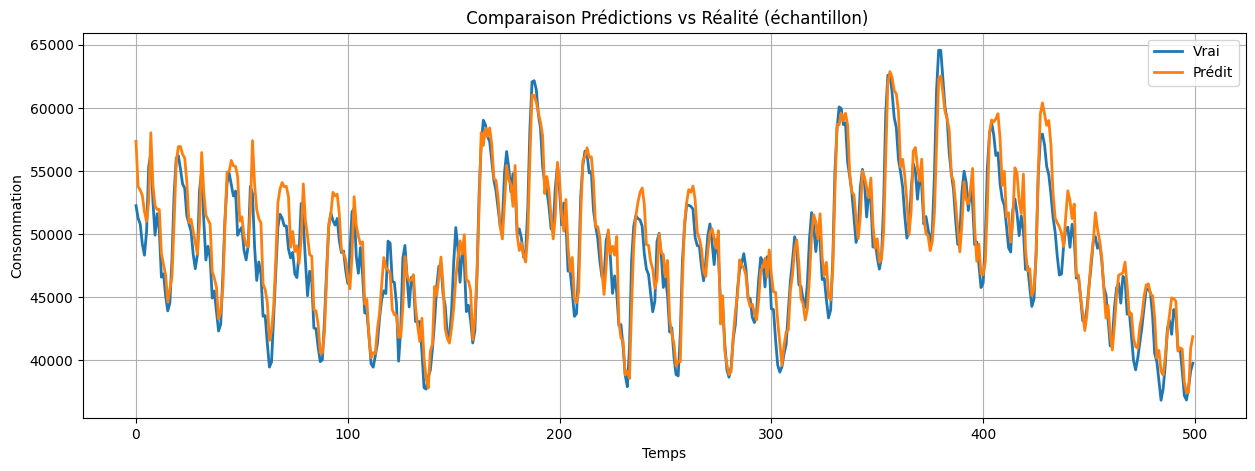

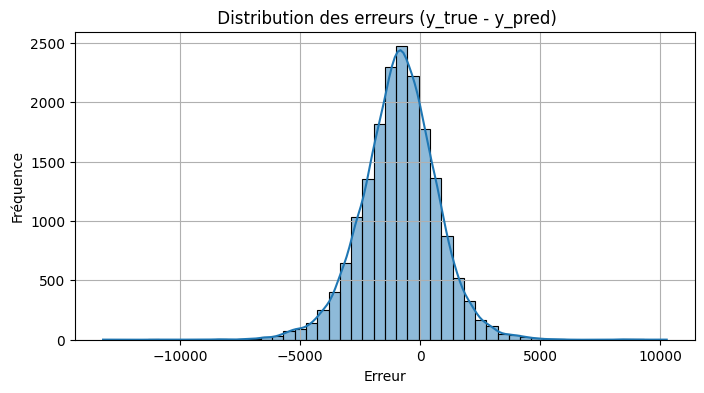

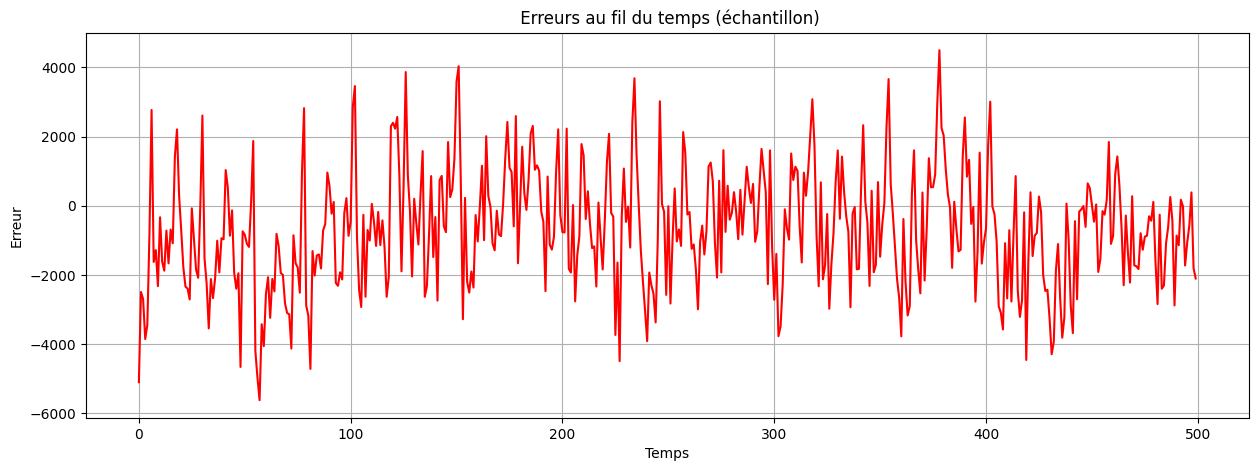

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Créer un dossier temporaire pour enregistrer les figures
os.makedirs("mlruns_artifacts", exist_ok=True)

# === 1. Courbe Prédit vs Vrai ===
plt.figure(figsize=(15, 5))
plt.plot(y_true[:500], label="Vrai", linewidth=2)
plt.plot(y_pred[:500], label="Prédit", linewidth=2)
plt.title(" Comparaison Prédictions vs Réalité (échantillon)")
plt.xlabel("Temps")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plot_path_1 = "mlruns_artifacts/pred_vs_true.png"
plt.savefig(plot_path_1)
mlflow.log_artifact(plot_path_1)

# === 2. Distribution des erreurs ===
errors = y_true.flatten() - y_pred.flatten()
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=50, kde=True)
plt.title(" Distribution des erreurs (y_true - y_pred)")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.grid(True)
plot_path_2 = "mlruns_artifacts/distribution_erreurs.png"
plt.savefig(plot_path_2)
mlflow.log_artifact(plot_path_2)

# === 3. Courbe des erreurs dans le temps ===
plt.figure(figsize=(15, 5))
plt.plot(errors[:500], color="red")
plt.title(" Erreurs au fil du temps (échantillon)")
plt.xlabel("Temps")
plt.ylabel("Erreur")
plt.grid(True)
plot_path_3 = "mlruns_artifacts/erreurs_temps.png"
plt.savefig(plot_path_3)
mlflow.log_artifact(plot_path_3)
